# CNN Attention

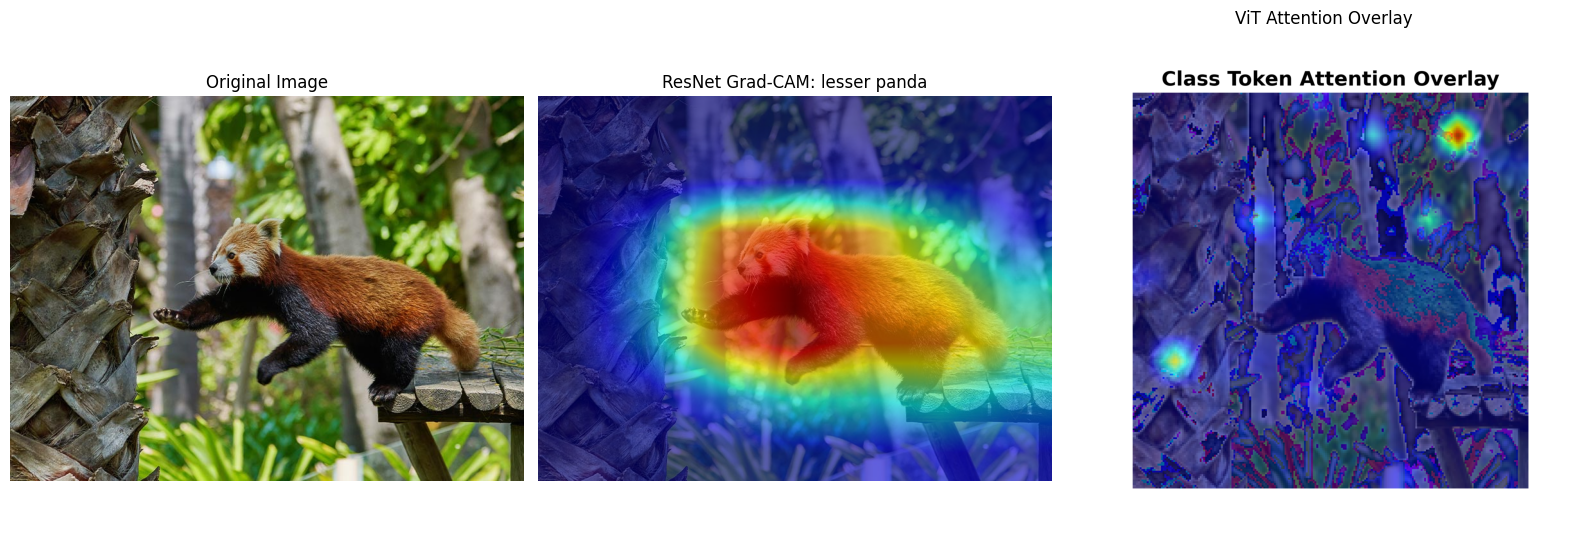

ResNet predicts: lesser panda
Comparison visualization saved to: ./figures/cnn_vs_vit_comparison.png


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import torchvision.transforms as transforms
import os
import requests

# Download ImageNet class labels if we don't have them
def get_imagenet_labels():
    # Create a simple mapping for ImageNet labels
    try:
        # Try to download labels from GitHub
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        labels = response.text.strip().split('\n')
        return {i: labels[i] for i in range(len(labels))}
    except:
        # If download fails, return a minimal set of labels
        return {
            0: "unknown",
            1: "goldfish",
            # Add a few more classes for common objects
            285: "red panda",
            386: "lesser panda",
            387: "giant panda"
        }

# Load pre-trained ResNet model
def load_resnet_model():
    model = models.resnet50(pretrained=True)
    model.eval()
    return model

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        model_output = self.model(input_tensor)
        
        if target_class is None:
            target_class = torch.argmax(model_output)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Target for backprop
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0, target_class] = 1
        
        # Backward pass
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        
        # Get weights from gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = F.relu(cam)  # ReLU to only focus on features that positively influence the class
        
        # Normalize CAM
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-10)
        
        return cam.detach().cpu().numpy(), target_class.item()

# Image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    
    return input_tensor, image

# Overlay heatmap on image
def overlay_heatmap(image, heatmap, alpha=0.6):
    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (image.width, image.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Convert PIL image to numpy array
    image_np = np.array(image)
    
    # Overlay
    overlay = (1 - alpha) * image_np + alpha * heatmap
    overlay = np.uint8(overlay)
    
    return overlay

# Compare CNN and ViT visualizations
def compare_visualizations(image_path, vit_attention_path):
    # Load and preprocess image
    input_tensor, original_image = preprocess_image(image_path)
    
    # Load ResNet model
    resnet_model = load_resnet_model()
    
    # Create Grad-CAM for the last convolutional layer of ResNet
    grad_cam = GradCAM(resnet_model, resnet_model.layer4[-1])
    
    # Generate Grad-CAM heatmap
    cam, predicted_class = grad_cam.generate_cam(input_tensor)
    
    # Get class name
    imagenet_labels = get_imagenet_labels()
    class_name = imagenet_labels.get(predicted_class, f"Class {predicted_class}")
    
    # Overlay Grad-CAM on original image
    resnet_overlay = overlay_heatmap(original_image, cam)
    
    # Load ViT attention map
    vit_overlay = cv2.imread(vit_attention_path)
    vit_overlay = cv2.cvtColor(vit_overlay, cv2.COLOR_BGR2RGB)
    
    # Display the results
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(resnet_overlay)
    plt.title(f"ResNet Grad-CAM: {class_name}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(vit_overlay)
    plt.title("ViT Attention Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("./figures/cnn_vs_vit_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"ResNet predicts: {class_name}")
    print("Comparison visualization saved to: ./figures/cnn_vs_vit_comparison.png")

# Run the comparison
image_path = "../data/images/lesser_panda3.jpg"
vit_attention_path = "./figures/final_layer_avg_attention_overlay.png"

# Make sure the figures directory exists
os.makedirs("./figures", exist_ok=True)

# Run the comparison
compare_visualizations(image_path, vit_attention_path)